In [4]:
pip install opencv-python numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


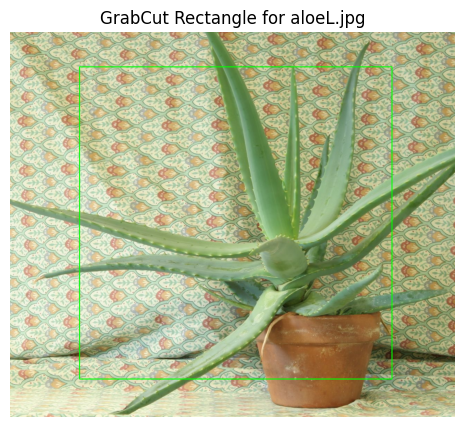

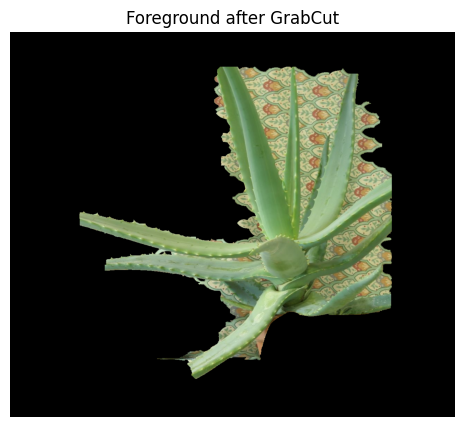

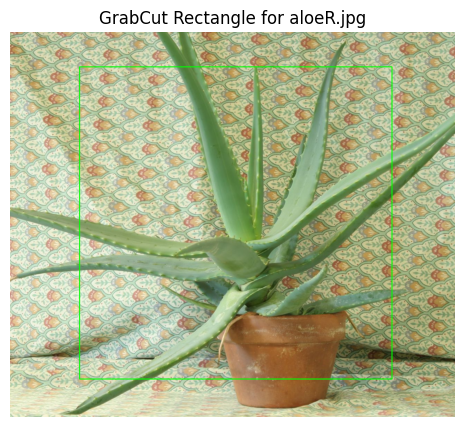

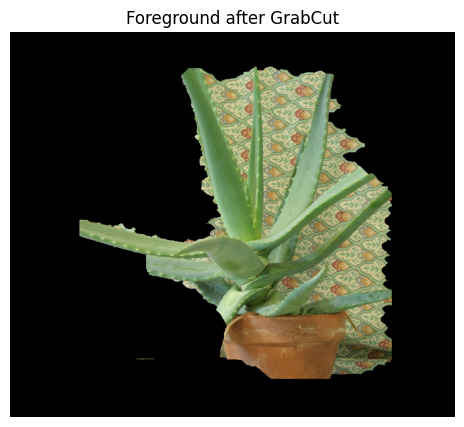

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grabcut_foreground(img_path, rect):
    """
    Apply GrabCut to extract foreground (plant + pot) from background.
    Displays intermediate and final results.
    """
    # Load image
    img = cv2.imread(img_path)
    
    # Stage 0: Show initial rectangle for reference
    img_copy = img.copy()
    x, y, w, h = rect
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(8,5))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"GrabCut Rectangle for {img_path}")
    plt.axis('off')
    plt.show()
    
    # Stage 1: GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Probable foreground mask
    mask_clean = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img_fg = img * mask_clean[:, :, np.newaxis]
    
    # Display foreground
    plt.figure(figsize=(8,5))
    plt.imshow(cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB))
    plt.title("Foreground after GrabCut")
    plt.axis('off')
    plt.show()
    
    return img_fg

# Define rectangles roughly around the plant + pot
rectL = (200, 100, 900, 900)  # adjust as needed for aloeL
rectR = (200, 100, 900, 900)  # adjust as needed for aloeR

# Process both images
foreground_L = grabcut_foreground('aloeL.jpg', rectL)
foreground_R = grabcut_foreground('aloeR.jpg', rectR)


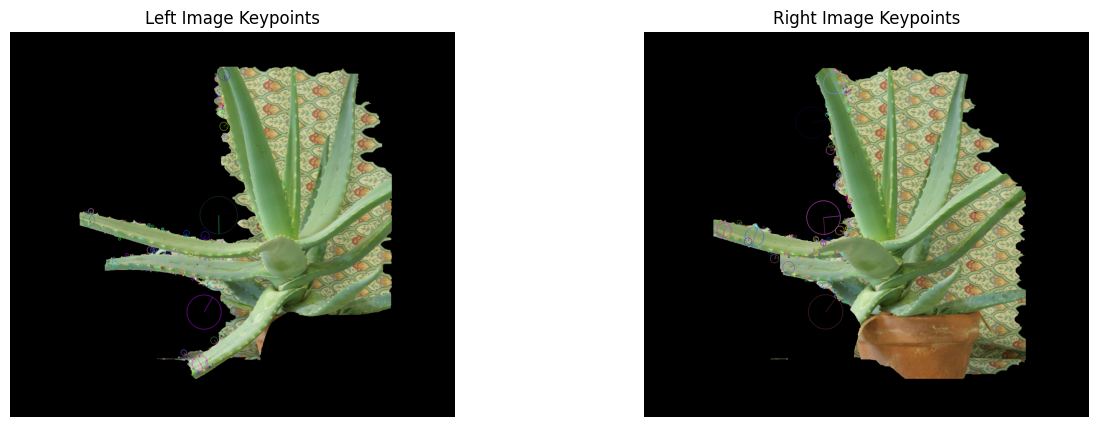

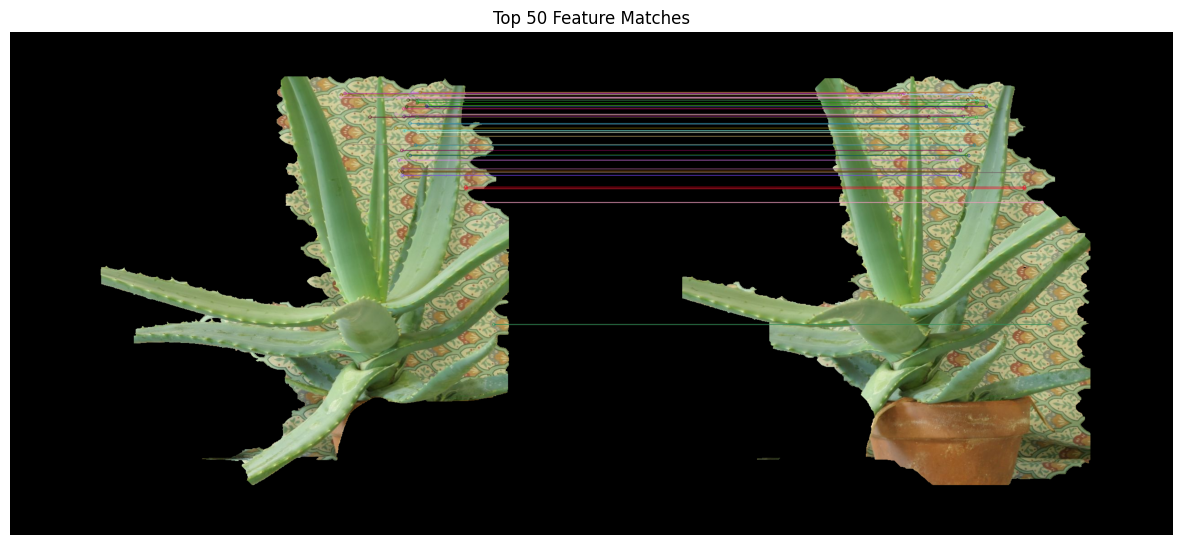

Number of inlier matches: 522
Fundamental Matrix F:
 [[ 2.45459304e-05 -7.29721611e-05 -3.41465020e-01]
 [ 7.50373710e-05 -6.88496437e-06  8.00228951e-02]
 [ 3.01925200e-01 -8.94478655e-02  1.00000000e+00]]
Rotation Matrix R:
 [[ 0.08544668  0.32349179  0.94236507]
 [ 0.34601956  0.87731933 -0.3325376 ]
 [-0.93432828  0.35449098 -0.03697046]]
Translation Vector t:
 [[ 3.32604085e-01]
 [ 9.43066527e-01]
 [-2.19672243e-04]]


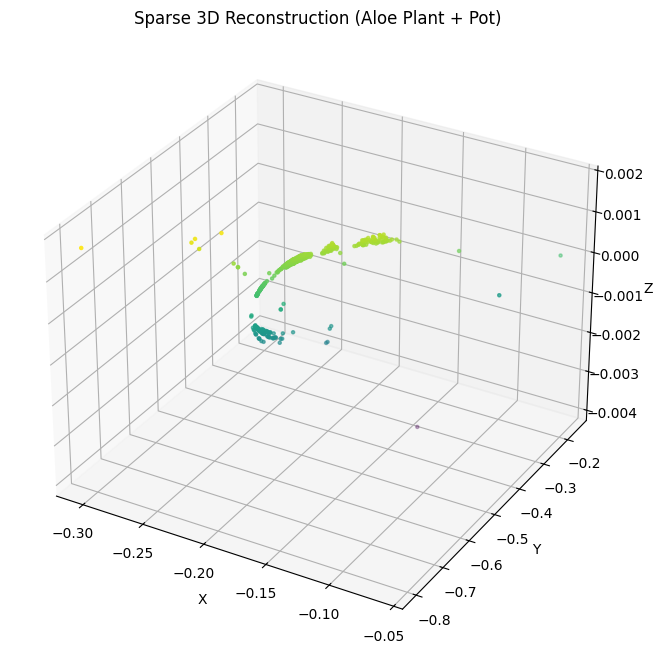

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------
# Stage 1: Feature Hunt (SIFT)
# -------------------------------
sift = cv2.SIFT_create()

# Convert foreground images to grayscale
gray_L = cv2.cvtColor(foreground_L, cv2.COLOR_BGR2GRAY)
gray_R = cv2.cvtColor(foreground_R, cv2.COLOR_BGR2GRAY)

# Detect keypoints and compute descriptors
kp_L, des_L = sift.detectAndCompute(gray_L, None)
kp_R, des_R = sift.detectAndCompute(gray_R, None)

# Draw top 100 keypoints
img_L_kp = cv2.drawKeypoints(foreground_L, kp_L[:300], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_R_kp = cv2.drawKeypoints(foreground_R, kp_R[:300], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_L_kp, cv2.COLOR_BGR2RGB))
plt.title("Left Image Keypoints")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_R_kp, cv2.COLOR_BGR2RGB))
plt.title("Right Image Keypoints")
plt.axis('off')
plt.show()

# -------------------------------
# Stage 2: Feature Matching
# -------------------------------
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des_L, des_R)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 50 matches
img_matches = cv2.drawMatches(foreground_L, kp_L, foreground_R, kp_R, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Top 50 Feature Matches")
plt.axis('off')
plt.show()

# -------------------------------
# Stage 3: Fundamental Matrix (RANSAC)
# -------------------------------
pts_L = np.float32([kp_L[m.queryIdx].pt for m in matches])
pts_R = np.float32([kp_R[m.trainIdx].pt for m in matches])

F, mask = cv2.findFundamentalMat(pts_L, pts_R, cv2.FM_RANSAC)
pts_L_inliers = pts_L[mask.ravel()==1]
pts_R_inliers = pts_R[mask.ravel()==1]

print(f"Number of inlier matches: {len(pts_L_inliers)}")
print("Fundamental Matrix F:\n", F)

# -------------------------------
# Stage 4: Camera Pose
# -------------------------------
h, w = gray_L.shape
focal_length = 1.0
K = np.array([[focal_length,0,w/2],
              [0,focal_length,h/2],
              [0,0,1]])

E = K.T @ F @ K
_, R, t, mask_pose = cv2.recoverPose(E, pts_L_inliers, pts_R_inliers, K)

print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)

# -------------------------------
# Stage 5: 3D Reconstruction
# -------------------------------
# Convert to homogeneous points for triangulation
pts_L_h = cv2.undistortPoints(np.expand_dims(pts_L_inliers, axis=1), K, None)
pts_R_h = cv2.undistortPoints(np.expand_dims(pts_R_inliers, axis=1), K, None)

# Projection matrices
P1 = np.hstack((np.eye(3), np.zeros((3,1))))
P2 = np.hstack((R, t))

# Triangulate points
points_4d_hom = cv2.triangulatePoints(P1, P2, pts_L_h, pts_R_h)
points_3d = points_4d_hom[:3] / points_4d_hom[3]

# 3D scatter plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[0], points_3d[1], points_3d[2], c=points_3d[2], cmap='viridis', s=5)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Sparse 3D Reconstruction (Aloe Plant + Pot)')
plt.show()


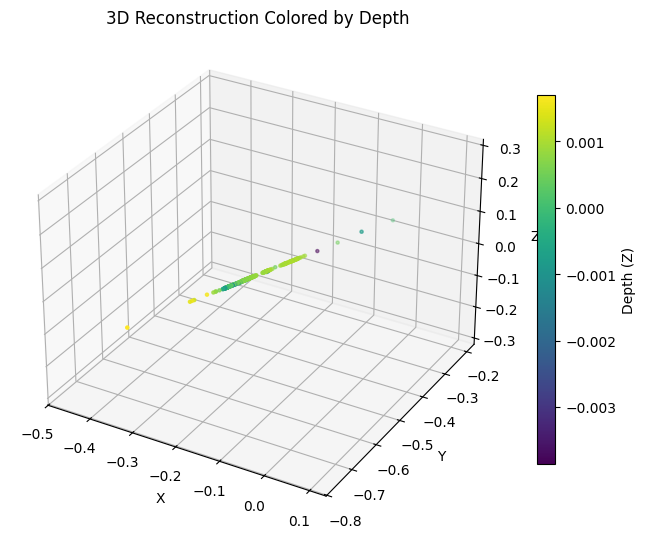

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Unpack points_3d array
X, Y, Z = points_3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapped to depth (Z)
scatter = ax.scatter(X, Y, Z, c=Z, cmap='viridis', s=5)

# Add colorbar for depth reference
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Depth (Z)')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction Colored by Depth')

# Use equal aspect ratio for all axes
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()
